## Practice Session 5
### Practicing different aspects of community detection and evaluation.

Today we are going to learn more about community detection by doing.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import community as louvain #if you don't have this: run pip install python-louvain
from networkx.algorithms import community
import matplotlib.pyplot as plt
import random

%matplotlib inline

### 1. Communities in Random graphs
- Generate an Erdos Renyi graph with 250 nodes and average degree 5. (What is p?)

In [28]:
G = nx.erdos_renyi_graph(250,5/(250-1))
np.mean([x[1] for x in nx.degree(G)])

5.176

- Detect communities using the Louvain method and print the modularity. Are you surprised?


In [29]:
er_louvain_partition =louvain.best_partition(G)
print(louvain.modularity(er_louvain_partition,G))

0.4215771758371177


- Create 100 Erdos Renyi graphs with the same parameters, calculate the modularity of the best Louvain partition, and plot their distribution as a histogram.

(0, 1)

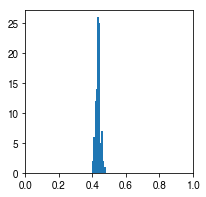

In [22]:
list_of_er_modularities = []
for _ in range(100):
    G = nx.erdos_renyi_graph(250,5/(250-1))
    er_louvain_partition =louvain.best_partition(G)
    list_of_er_modularities.append(louvain.modularity(er_louvain_partition,G))
plt.figure(figsize=(3,3))
plt.hist(list_of_er_modularities)
plt.xlim([0,1])

- The Louvain method finds non-zero modularity partitions of random networks very consistently! This means we should always compare the modularity of partitions of real networks with similar random ones...

### 2. Comparing the Karate Club's Modularity with a similar random network
- Load in the Karate club graph

In [6]:
K=nx.karate_club_graph()

- Create 200 Erdos Renyi graphs with the same number of nodes and average degree as the Karate Club graph. Calculate their modularities under a Louvain partition. Then calculate the modularity of the Louvain partition of the real Karate club network. Plot the distribution of Erdos Renyi modularities as a histogram and indicate with a vertical red line the true network's Louvain modularity.

In [7]:
#first find the parameters for the ER networks...
kc_avg_degree= np.mean([x[1] for x in K.degree()])
kc_n_nodes = len(K.nodes())
er_p = kc_avg_degree/(kc_n_nodes-1)
print(er_p)

0.13903743315508021


In [8]:
list_of_er_modularities = []

for _ in range(200):
    G = nx.erdos_renyi_graph(kc_n_nodes,er_p)
    er_louvain_partition =louvain.best_partition(G)
    list_of_er_modularities.append(louvain.modularity(er_louvain_partition,G))

kc_mod = louvain.modularity(louvain.best_partition(K),K)    

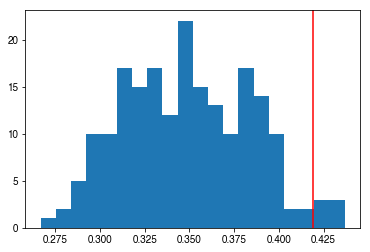

In [9]:
plt.hist(list_of_er_modularities,bins= 20)
plt.axvline(kc_mod,color='red')

- Repeat this process with a configuration model for the random graph.

In [10]:
list_of_cm_modularities = []

for _ in range(200):
    G = nx.configuration_model([x[1] for x in K.degree()])
    er_louvain_partition =louvain.best_partition(G)
    list_of_cm_modularities.append(louvain.modularity(er_louvain_partition,G))


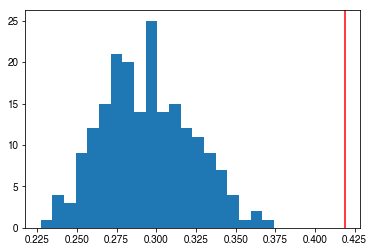

In [11]:
plt.hist(list_of_cm_modularities,bins= 20)
plt.axvline(kc_mod,color='red')

## 3. Do random walkers stay within communities?

- Write a function that simulates a random walk of k steps on a network. It should first place a random walker at node in the network, then take k steps recording the nodes the walker visits in a list. It should return that list.

In [32]:
def random_walk(input_graph,steps):
    current_position = random.choice(list(input_graph.nodes()))
    nodes_visited = [current_position]
    for step in range(steps):
        neighbors =list(input_graph[current_position])
        current_position = random.choice(neighbors)
        nodes_visited.append(current_position)
    return nodes_visited

In [36]:
random_walk(K,5)

[20, 32, 29, 23, 33, 27]

- Plot the network with the nodes visited in a random walk of length 10 in a different color from the rest of the nodes.

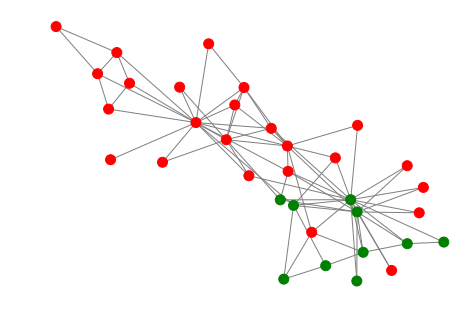

In [44]:
walk = list(set(random_walk(K,15)))
color_map = []
edge_color_map = []
for node in K:
    if node in walk:
        color_map.append('green')
    else:
        color_map.append('red')

    
nx.draw_spring(K, node_color=color_map, node_size=100, edge_color='grey')

- Let a random walker run for 500 steps. Map the resulting sequence of nodes to a sequence of 1's and 0's: 1 if the node visited is in the "Mr. Hi" group and 0 if the node visited is in the "Officer" group. You can get the ground truth partition of the Karate club using: nx.get_node_attributes(K,'club')

In [48]:
true_partition = nx.get_node_attributes(K,'club')

binary_sequence = []
for visited_node in random_walk(K,500):
    if true_partition[visited_node] =='Mr. Hi':
        binary_sequence.append(1)
    else:
        binary_sequence.append(0)

- Plot the sequence of ones and zeros.

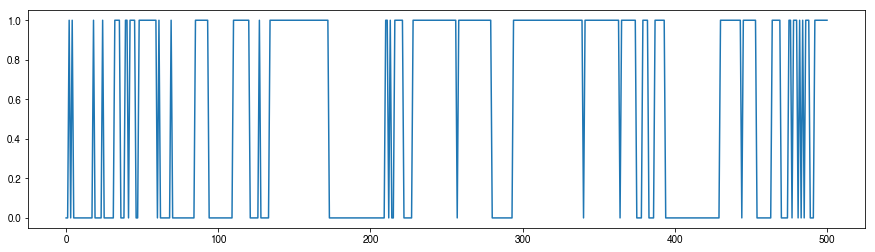

In [49]:
plt.figure(figsize=(15,4))
plt.plot(binary_sequence)

- Calculate how long the walker typically stays within a group. Plot these lengths as a histogram.

(array([39., 10.,  7.,  2.,  2.,  0.,  1.,  1.,  2.,  1.]),
 array([ 0. ,  4.5,  9. , 13.5, 18. , 22.5, 27. , 31.5, 36. , 40.5, 45. ]),
 <a list of 10 Patch objects>)

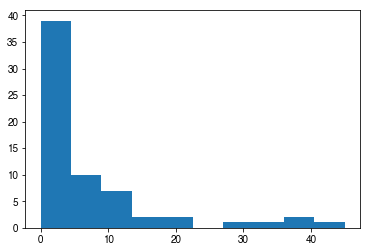

In [50]:
previous = binary_sequence[0]
within_group_walk_lengths = []
length= 0

for group in binary_sequence[1:]:
    if group == previous:
        length+=1
    else:
        within_group_walk_lengths.append(length)
        length = 0
        previous = group

plt.hist(within_group_walk_lengths)

Now let the walker take 10,000 steps and again plot how long the walker stays in a group. You can use a log-log scale!

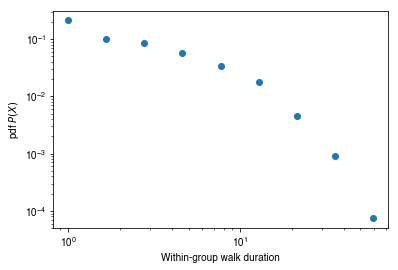

In [51]:
true_partition = nx.get_node_attributes(K,'club')

binary_sequence = []
for visited_node in random_walk(K,100000):
    if true_partition[visited_node] =='Mr. Hi':
        binary_sequence.append(1)
    else:
        binary_sequence.append(0)
        
previous = binary_sequence[0]
within_group_walk_lengths = []
length= 0

for group in binary_sequence[1:]:
    if group == previous:
        length+=1
    else:
        within_group_walk_lengths.append(length)
        length = 0
        previous = group

bin_edges = np.logspace(np.log10(1), np.log10(max(within_group_walk_lengths)), num=10)
density, _ = np.histogram(within_group_walk_lengths, bins=bin_edges, density=True)
fig02 = plt.figure()
plt.loglog(bin_edges[:-1], density, marker='o', linestyle='none')

plt.xlabel("Within-group walk duration")
plt.ylabel(r"pdf $P(X)$")
plt.show()

### For the ambitious: repeat the random-walk exercise on an Erdos Renyi graph with the same parameters as the Karate Club, partitioned using Louvain.

In [19]:
G = nx.erdos_renyi_graph(kc_n_nodes,er_p)
er_louvain_partition =louvain.best_partition(G)


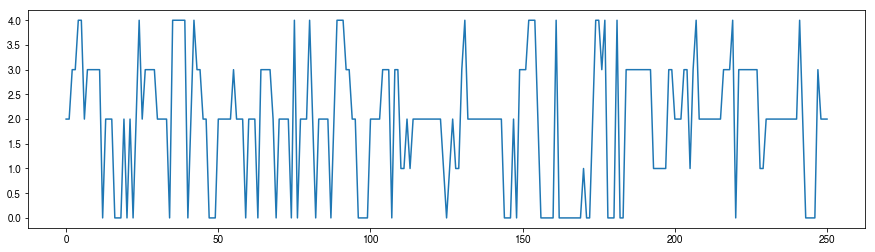

In [20]:
binary_sequence = []
for visited_node in random_walk(G,250):
    binary_sequence.append(er_louvain_partition[visited_node])
        
        
plt.figure(figsize=(15,4))
plt.plot(binary_sequence)

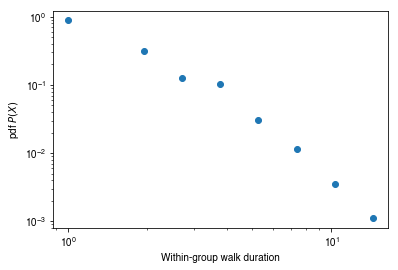

In [21]:
binary_sequence = []
for visited_node in random_walk(G,10000):
    binary_sequence.append(er_louvain_partition[visited_node])
        
        
previous = binary_sequence[0]
within_group_walk_lengths = []
length= 0

for group in binary_sequence[1:]:
    if group == previous:
        length+=1
    else:
        within_group_walk_lengths.append(length)
        length = 0
        previous = group

bin_edges = np.logspace(np.log10(1), np.log10(max(within_group_walk_lengths)), num=10)
density, _ = np.histogram(within_group_walk_lengths, bins=bin_edges, density=True)
fig02 = plt.figure()
plt.loglog(bin_edges[:-1], density, marker='o', linestyle='none')

plt.xlabel("Within-group walk duration")
plt.ylabel(r"pdf $P(X)$")
plt.show()